In [1]:
# Standard library
import os
import math
from functools import reduce

# Numerical / ML libraries
import numpy as np
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Subset

# PyTorch Geometric
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import (
    GCNConv,
    MessagePassing,
    global_add_pool,
    global_mean_pool,
    global_max_pool,
)
import torch_geometric.transforms as T
from torch_geometric.utils import (
    degree,
    dense_to_sparse,
    to_dense_adj,
    to_dense_batch,
    to_undirected,
)

# Sparse‐specific ops
from torch_scatter import scatter_add
from torch_sparse import SparseTensor, spspmm

# Utilities
from tqdm.notebook import tqdm
from transformers import get_cosine_schedule_with_warmup

In [2]:
class NormalizedDegree(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        deg = degree(data.edge_index[0], dtype=torch.float)
        deg = (deg - self.mean) / self.std
        data.x = deg.view(-1, 1)
        return data

def get_dataset(name, sparse=True, cleaned=False, normalize=False):
    dataset = TUDataset(os.path.join('./data', name), name, use_node_attr=True, cleaned=cleaned)
    dataset.data.edge_attr = None

    if dataset.data.x is None:
        max_degree = 0
        degs = []
        for data in dataset:
            degs += [degree(data.edge_index[0], dtype=torch.long)]
            max_degree = max(max_degree, degs[-1].max().item())

        if max_degree < 1000:
            dataset.transform = T.OneHotDegree(max_degree)
        else:
            deg = torch.cat(degs, dim=0).to(torch.float)
            mean, std = deg.mean().item(), deg.std().item()
            dataset.transform = NormalizedDegree(mean, std)

    elif normalize:

        dataset.data.x -= torch.mean(dataset.data.x, axis=0)
        dataset.data.x /= torch.std(dataset.data.x, axis=0)

    if not sparse:
        max_num_nodes = 0
        for data in dataset:
            max_num_nodes = max(data.num_nodes, max_num_nodes)

        if dataset.transform is None:
            dataset.transform = T.ToDense(max_num_nodes)
        else:
            dataset.transform = T.Compose(
                [dataset.transform, T.ToDense(max_num_nodes)])

    return dataset

def load_dataloader(fold_number, val_fold_number):
    data='PROTEINS'
    batch_size = 8
    train_idxes = torch.as_tensor(np.loadtxt('./datasets/%s/10fold_idx/train_idx-%d.txt' % (data, fold_number),
                                            dtype=np.int32), dtype=torch.long)
    val_idxes = torch.as_tensor(np.loadtxt('./datasets/%s/10fold_idx/test_idx-%d.txt' % (data, val_fold_number),
                                            dtype=np.int32), dtype=torch.long)     
    test_idxes = torch.as_tensor(np.loadtxt('./datasets/%s/10fold_idx/test_idx-%d.txt' % (data, fold_number),
                                            dtype=np.int32), dtype=torch.long)

    all_idxes = reduce(np.union1d, (train_idxes, val_idxes, test_idxes))
    assert len(all_idxes) == len(dataset)

    train_idxes = torch.as_tensor(np.setdiff1d(train_idxes, val_idxes))

    train_set, val_set, test_set = dataset[train_idxes], dataset[val_idxes], dataset[test_idxes]

    train_loader = DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(dataset=test_set, batch_size=batch_size,  shuffle=False)

    return train_loader, val_loader, test_loader

In [3]:
"""Unbatched implementation of SCCPNet """

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, normalize=False):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, normalize=normalize)
        self.bn1 = nn.BatchNorm1d(hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels, normalize=normalize)
        self.bn2 = nn.BatchNorm1d(hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels, normalize=normalize)
        self.bn3 = nn.BatchNorm1d(out_channels)

    def forward(self, x, edge_index, edge_weight=None):
        x = self.conv1(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.bn1(x)
        x = self.conv2(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.bn2(x)
        x = self.conv3(x, edge_index, edge_weight)
        x = F.relu(x)
        x = self.bn3(x)
        return x

class SCCPPoolLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters, eps=1e-3, lam=1.0):
        super(SCCPPoolLayer, self).__init__()
        self.assign_gnn = GNN(in_channels, hidden_channels, num_clusters)
        self.num_clusters = num_clusters
        self.eps = eps
        self.lam = lam

    def forward(self, x_sparse, edge_index_sparse, edge_weight_sparse):
        device = x_sparse.device
        N, C = x_sparse.size()
        k = self.num_clusters

        # Soft assignments
        s_logits = self.assign_gnn(x_sparse, edge_index_sparse, edge_weight_sparse)
        s = F.softmax(s_logits, dim=-1)

        # Centroids
        numerator = x_sparse.t().matmul(s).t()
        denom = s.sum(dim=0).clamp(min=1e-6)
        centroids = numerator / denom.unsqueeze(-1)

        # Broadcast back
        mu = s.matmul(centroids)

        # Clustering loss: fidelity + fusion
        diff = x_sparse - mu
        fidelity = 0.5 * diff.pow(2).sum()

        row, col = edge_index_sparse
        mu_row = mu[row]
        mu_col = mu[col]
        dist_sq_edges = (mu_row - mu_col).pow(2).sum(dim=-1)
        fusion = (edge_weight_sparse * torch.sqrt(dist_sq_edges + self.eps**2)).sum()

        cluster_loss = fidelity + self.lam * fusion

        # Pool features
        x_pooled = s.t().matmul(x_sparse)

        # Pool adjacency
        M = torch.zeros(N, k, device=device)
        M.index_add_(0, row, edge_weight_sparse.unsqueeze(-1) * s[col])
        A_pool = s.t().matmul(M)
        edge_index_pooled, edge_weight_pooled = dense_to_sparse(A_pool)

        return x_pooled, edge_index_pooled, edge_weight_pooled, cluster_loss, (s, centroids, mu)

class SCCPNet(nn.Module):
    def __init__(self, dataset, hidden_channels=128, ratio=0.6, lam=1.0):
        super(SCCPNet, self).__init__()
        num_features = dataset.num_features
        num_classes = dataset.num_classes

        # Pool sizes
        max_nodes = max(data.num_nodes for data in dataset)
        self.k1 = max(1, math.ceil(ratio * max_nodes))
        self.k2 = max(1, math.ceil(ratio * self.k1))
        self.k3 = max(1, math.ceil(ratio * self.k2))

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.pool1 = SCCPPoolLayer(hidden_channels, hidden_channels, self.k1, eps=1e-3, lam=lam)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.pool2 = SCCPPoolLayer(hidden_channels, hidden_channels, self.k2, eps=1e-3, lam=lam)

        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.pool3 = SCCPPoolLayer(hidden_channels, hidden_channels, self.k3, eps=1e-3, lam=lam)

        #self.lin1 = nn.Linear(2 * hidden_channels * 3, 128)
        self.lin1 = nn.Linear(2 * hidden_channels, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        device = x.device

        # Unweighted edges
        E = edge_index.size(1)
        edge_weight = torch.ones(E, device=device)

        x1 = F.relu(self.conv1(x, edge_index, edge_weight))
        x1_pooled, ei1, ew1, loss1, p1 = self.pool1(x1, edge_index, edge_weight, data.batch)
        batch1 = torch.zeros(x1_pooled.size(0), dtype=torch.long, device=device)
        #x1_mean = global_mean_pool(x1_pooled, batch1)
        #x1_max  = global_max_pool(x1_pooled, batch1)
        #x1_repr = torch.cat([x1_mean, x1_max], dim=1)
        x1_repr = global_add_pool(x1_pooled, batch1)

        x2 = F.relu(self.conv2(x1_pooled, ei1, ew1))
        x2_pooled, ei2, ew2, loss2, _ = self.pool2(x2, ei1, ew1, data.batch)
        batch2 = torch.zeros(x2_pooled.size(0), dtype=torch.long, device=device)
        #x2_mean = global_mean_pool(x2_pooled, batch2)
        #x2_max  = global_max_pool(x2_pooled, batch2)
        #x2_repr = torch.cat([x2_mean, x2_max], dim=1)
        x2_repr = global_add_pool(x2_pooled, batch2)

        x3 = F.relu(self.conv3(x2_pooled, ei2, ew2))
        x3_pooled, ei3, ew3, loss3, _ = self.pool3(x3, ei2, ew2, data.batch)
        batch3 = torch.zeros(x3_pooled.size(0), dtype=torch.long, device=device)
        #x3_mean = global_mean_pool(x3_pooled, batch3)
        #x3_max  = global_max_pool(x3_pooled, batch3)
        #x3_repr = torch.cat([x3_mean, x3_max], dim=1)
        x3_repr = global_add_pool(x3_pooled, batch3)

        # Sum the three representations
        x_sum = torch.cat([x1_repr, x2_repr, x3_repr], dim=1)

        # Final MLP
        x_out = F.relu(self.lin1(x_sum))
        #x_out = F.dropout(x_out, p=0.5, training=self.training)
        x_out = F.relu(self.lin2(x_out))
        #x_out = F.dropout(x_out, p=0.5, training=self.training)
        x_out = F.log_softmax(self.lin3(x_out), dim=-1).squeeze(0)

        total_cluster_loss = loss1 + loss2 + loss3
        return x_out, total_cluster_loss, p1, x1

In [4]:
"""Batched implementation of SCCPNet """

class DenseGCNConv(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super().__init__()
        self.lin = nn.Linear(in_channels, out_channels, bias=False)
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_channels))
        else:
            self.register_parameter('bias', None)

    def forward(self, x_blk, adj_blk):
        h = torch.bmm(adj_blk, x_blk)
        h = self.lin(h)
        if self.bias is not None:
            h = h + self.bias
        return h

def normalize_adj(adj):
    B, N, _ = adj.size()
    I = torch.eye(N, device=adj.device).unsqueeze(0).expand(B, N, N)
    A_hat = adj + I
    deg    = A_hat.sum(-1)
    deg_inv_sqrt = deg.pow(-0.5).unsqueeze(-1)
    return deg_inv_sqrt * A_hat * deg_inv_sqrt.transpose(1,2)

class SCCPPoolLayer(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_clusters,
                 eps: float = 1e-3, lam: float = 1.0):
        super().__init__()
        self.k   = num_clusters
        self.eps = eps
        self.lam = lam
        self.conv1 = DenseGCNConv(in_channels, hidden_channels)
        self.conv2 = DenseGCNConv(hidden_channels, hidden_channels)
        self.conv3 = DenseGCNConv(hidden_channels, hidden_channels)
        self.lin   = nn.Linear(hidden_channels, num_clusters)

    def forward(self, x, edge_index, edge_weight, batch):
        device = x.device
        N, C_in = x.size()
        B       = int(batch.max()) + 1
        k       = self.k

        x_blk, mask = to_dense_batch(x, batch)
        A_blk       = to_dense_adj(edge_index, batch, edge_attr=edge_weight)
        A_norm = normalize_adj(A_blk)

        # Soft assignments
        h = F.relu(self.conv1(x_blk, A_norm))
        h = F.relu(self.conv2(h,     A_norm))
        h = F.relu(self.conv3(h,     A_norm))
        S_logits_blk = self.lin(h)

        S_blk = torch.softmax(S_logits_blk, dim=-1)
        S_blk = S_blk * mask.unsqueeze(-1)

        # Centroids
        numer = torch.bmm(S_blk.transpose(1, 2), x_blk)
        m = S_blk.sum(dim=1)
        Cb = numer / (m.unsqueeze(-1) + self.eps)

        # Broadcast back
        mu_blk = torch.bmm(S_blk, Cb)

        # Fidelity Loss
        fidelity_term = (x_blk - mu_blk).pow(2)
        fidelity = 0.5 * (fidelity_term * mask.unsqueeze(-1)).sum()

        # Fusion Loss
        mu = mu_blk[mask]
        
        row, col  = edge_index
        dmu       = mu[row] - mu[col]
        dist_edge = torch.sqrt(dmu.pow(2).sum(dim=-1) + self.eps**2)
        fusion    = (edge_weight * dist_edge).sum()
        
        cluster_loss = fidelity + self.lam * fusion

        # Pool features
        x_pooled = Cb.view(B * k, C_in)

        # Pool adjacency
        A_pool_blk = torch.bmm(torch.bmm(S_blk.transpose(1, 2), A_blk), S_blk)

        # Unpack to sparse
        ei_list, ew_list = [], []
        for b in range(B):
            ei_b, ew_b = dense_to_sparse(A_pool_blk[b])
            ei_b = ei_b + b * k
            ei_list.append(ei_b)
            ew_list.append(ew_b)

        edge_index_pool  = torch.cat(ei_list, dim=1)
        edge_weight_pool = torch.cat(ew_list, dim=0)
        mask0 = mask[0]
        nodes = mask0.nonzero(as_tuple=True)[0]
        return x_pooled, edge_index_pool, edge_weight_pool, cluster_loss, (S_blk[0][mask0], Cb[0], mu_blk[0][mask0], x_blk[0][mask0], A_blk[0][nodes][:, nodes])
    
class SCCPNet(nn.Module):
    def __init__(self, dataset, hidden_channels=128, ratio=0.6, lam=1.0):
        super().__init__()
        num_features = dataset.num_features
        num_classes  = dataset.num_classes

        max_nodes = max(data.num_nodes for data in dataset)
        self.k1 = max(1, math.ceil(ratio * max_nodes))
        self.k2 = max(1, math.ceil(ratio * self.k1))
        self.k3 = max(1, math.ceil(ratio * self.k2))

        self.conv1 = GCNConv(num_features, hidden_channels)
        self.pool1 = SCCPPoolLayer(hidden_channels, hidden_channels, self.k1, lam=lam)

        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.pool2 = SCCPPoolLayer(hidden_channels, hidden_channels, self.k2, lam=lam)

        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.pool3 = SCCPPoolLayer(hidden_channels, hidden_channels, self.k3, lam=lam)

        # final classifier
        #self.lin1 = nn.Linear(6 * hidden_channels, 128)
        self.lin1 = nn.Linear(3 * hidden_channels, 128)
        self.lin2 = nn.Linear(128, 64)
        self.lin3 = nn.Linear(64, num_classes)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        device = x.device
        B      = int(batch.max()) + 1

        # unweighted edges
        E = edge_index.size(1)
        ew = x.new_ones(E)

        x1 = F.relu(self.conv1(x, edge_index, ew))
        x1p, ei1, ew1, loss1, p1 = self.pool1(x1, edge_index, ew, batch)
        batch1 = torch.arange(B, device=device).repeat_interleave(self.k1)
        #x1_mean = global_mean_pool(x1p, batch1)
        #x1_max  = global_max_pool(x1p, batch1)
        #x1_repr = torch.cat([x1_mean, x1_max], dim=1)
        x1_repr = global_add_pool(x1p, batch1)

        x2 = F.relu(self.conv2(x1p, ei1, ew1))
        x2p, ei2, ew2, loss2, _ = self.pool2(x2, ei1, ew1, batch1)
        batch2 = torch.arange(B, device=device).repeat_interleave(self.k2)
        #x2_mean = global_mean_pool(x2p, batch2)
        #x2_max  = global_max_pool(x2p, batch2)
        #x2_repr = torch.cat([x2_mean, x2_max], dim=1)
        x2_repr = global_add_pool(x2p, batch2)

        x3 = F.relu(self.conv3(x2p, ei2, ew2))
        x3p, ei3, ew3, loss3, _ = self.pool3(x3, ei2, ew2, batch2)
        batch3 = torch.arange(B, device=device).repeat_interleave(self.k3)
        #x3_mean = global_mean_pool(x3p, batch3)
        #x3_max  = global_max_pool(x3p, batch3)
        #x3_repr = torch.cat([x3_mean, x3_max], dim=1)
        x3_repr = global_add_pool(x3p, batch3)

        cluster_loss = loss1 + loss2 + loss3

        # final readout
        x_cat = torch.cat([x1_repr, x2_repr, x3_repr], dim=1)
        h = F.relu(self.lin1(x_cat))
        #h = F.dropout(h, p=0.1, training=self.training)
        h = F.relu(self.lin2(h))
        #h = F.dropout(h, p=0.1, training=self.training)
        out = self.lin3(h)
        return F.log_softmax(out, dim=-1), cluster_loss, p1

In [5]:
def train(
    model,
    loader,
    val_loader,
    optimizer,
    scheduler,
    device,
    alpha: float = 0.1,
    accumulation_steps: int = 1,
):
    model.train()
    optimizer.zero_grad()

    total_cls_loss = 0.0
    total_reg_loss = 0.0
    total_graphs   = 0
    global_step    = 0
    patience       = 0.0

    for idx, batch in enumerate(loader):
        batch = batch.to(device)
        logits, cluster_loss, p1 = model(batch)
        target = batch.y.view(-1).to(device)

        # sum rather than mean so we can accumulate properly
        cls_loss_sum = F.nll_loss(logits, target, reduction='sum')
        reg_loss_sum = cluster_loss

        loss = (cls_loss_sum + alpha * reg_loss_sum) / accumulation_steps
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        total_cls_loss += cls_loss_sum.item()
        total_reg_loss += reg_loss_sum.item()
        total_graphs   += batch.num_graphs

        if (idx + 1) % accumulation_steps == 0:
            optimizer.step()
            scheduler.step()          # <-- step the scheduler here
            optimizer.zero_grad()
            global_step += 1

    # catch any remaining grads
    if len(loader) % accumulation_steps != 0:
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        global_step += 1

    avg_loss = (total_cls_loss + alpha * total_reg_loss) / total_graphs
    return avg_loss, p1

@torch.no_grad()
def eval(model, loader, device):
    model.eval()
    correct, total, loss = 0, 0, 0
    
    for batch in loader:
        batch = batch.to(device)
        logits, *_ = model(batch)             # ignore cluster loss
        pred = logits.argmax(dim=-1)
        
        target = batch.y.view(-1).to(device)

        # sum rather than mean so we can accumulate properly
        l = F.nll_loss(logits, target, reduction='sum')
        
        correct += (pred == batch.y.to(device)).sum().item()
        total   += batch.num_graphs
        loss    += l

    return correct / total, loss / total

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load PROTEINS dataset
dataset = get_dataset('PROTEINS')
train_loader, val_loader, test_loader = load_dataloader(1,1)

/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/torch_geometric/data/dataset.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  if osp.exists(f) and 

In [7]:
model = SCCPNet(dataset, hidden_channels=128, ratio=0.2, lam=100).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

num_epochs            = 500
accumulation_steps    = 16
eff_batch_size = accumulation_steps * 8
max_patience              = 50
train_steps_per_epoch = len(train_loader) // eff_batch_size + (1 if len(train_loader) % eff_batch_size != 0 else 0)
total_training_steps  = num_epochs * train_steps_per_epoch
warmup_steps          = int(0.1 * total_training_steps) 

scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps,
)

best_loss = np.inf
patience = 0.0
for epoch in tqdm(range(1, num_epochs + 1), desc="Epoch"):
    loss, p1 = train(
        model,
        train_loader,
        val_loader,
        optimizer,
        scheduler,
        device,
        accumulation_steps=accumulation_steps,
    )
    acc, _ = eval(model, test_loader, device)
    val_acc, val_loss = eval(model, val_loader, device)
    if val_loss < best_loss:
        best_loss = val_loss
        patience = 0
    else:
        patience += 1        
    
    print(f'Epoch {epoch:03d}/{num_epochs:03d} | Train Loss: {loss:.4f} | Val Acc {val_acc:.4f} ({patience:.0f}) | Test Acc: {acc:.4f}')
    if patience > max_patience:
        pass

Epoch:   0%|          | 0/500 [00:00<?, ?it/s]

Epoch 001/500 | Train Loss: 85.1602 | Val Acc 0.5946 (0) | Test Acc: 0.5946
Epoch 002/500 | Train Loss: 84.5717 | Val Acc 0.4505 (0) | Test Acc: 0.4505
Epoch 003/500 | Train Loss: 83.3700 | Val Acc 0.6577 (0) | Test Acc: 0.6577
Epoch 004/500 | Train Loss: 82.0894 | Val Acc 0.5946 (1) | Test Acc: 0.5946
Epoch 005/500 | Train Loss: 80.9566 | Val Acc 0.6757 (0) | Test Acc: 0.6757
Epoch 006/500 | Train Loss: 77.1762 | Val Acc 0.6216 (1) | Test Acc: 0.6216
Epoch 007/500 | Train Loss: 75.6268 | Val Acc 0.4054 (2) | Test Acc: 0.4054
Epoch 008/500 | Train Loss: 70.8272 | Val Acc 0.5856 (3) | Test Acc: 0.5856
Epoch 009/500 | Train Loss: 68.0248 | Val Acc 0.6757 (4) | Test Acc: 0.6757
Epoch 010/500 | Train Loss: 66.5286 | Val Acc 0.5766 (5) | Test Acc: 0.5766
Epoch 011/500 | Train Loss: 63.2001 | Val Acc 0.4414 (6) | Test Acc: 0.4414
Epoch 012/500 | Train Loss: 61.7091 | Val Acc 0.4054 (7) | Test Acc: 0.4054
Epoch 013/500 | Train Loss: 58.9177 | Val Acc 0.4054 (8) | Test Acc: 0.4054
Epoch 014/50

In [15]:
for idx, batch in enumerate(train_loader):
    batch = batch.to(device)
    logits, cluster_loss, p1 = model(batch)
    break

/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
/home/chester/miniconda3/envs/ml-gener

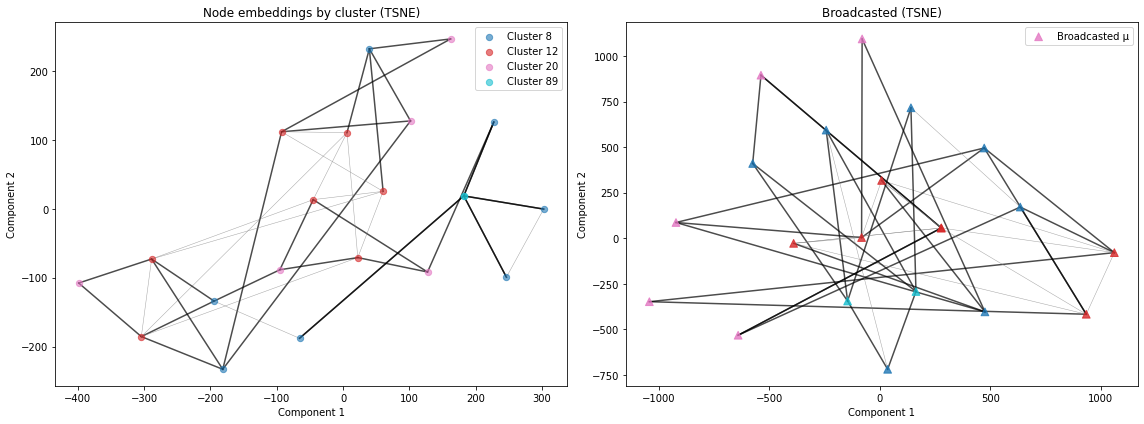

In [17]:
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import networkx as nx
def visualize_embeddings(s,
                         centroids,
                         mu,
                         x_embed,
                         adjacency=None,
                         method='pca',
                         cmap_name='tab10',
                         random_state=0,
                         plot_centroids=True):
    """
    s:               torch.Tensor of shape [N, K] (soft assignments)
    centroids:       torch.Tensor of shape [C, D]
    mu:              torch.Tensor of shape [N, D]
    x_embed:         torch.Tensor of shape [N, D]
    adjacency:       Optional N×N array (dense, sparse, or torch.Tensor)
    method:          'pca' or 'tsne'
    cmap_name:       any matplotlib cmap name
    random_state:    RNG seed for TSNE
    plot_centroids:  bool, whether to scatter the centroids
    """
    # ———————————————————————————————————————————————————————————————
    # 1) cluster assignments → 0..C-1
    cluster_ids = s.argmax(dim=1).cpu().numpy()
    unique_ids  = np.unique(cluster_ids)
    id_to_idx   = {cid: idx for idx, cid in enumerate(unique_ids)}
    cluster_idx = np.array([id_to_idx[c] for c in cluster_ids])
    num_clusters = len(unique_ids)

    # 2) to numpy
    x_np         = x_embed.detach().cpu().numpy()
    mu_np        = mu.detach().cpu().numpy()
    centroids_np = centroids.detach().cpu().numpy()

    # 3) normalize rows → unit norm
    x_np         = normalize(x_np, axis=1)
    mu_np        = normalize(mu_np, axis=1)
    centroids_np = normalize(centroids_np, axis=1)

    # 4) center everything on mean of x
    mean_vec = x_np.mean(axis=0)
    x_np        -= mean_vec
    mu_np       -= mean_vec
    centroids_np-= mean_vec

    # — embed to 2D
    if method.lower() == 'tsne':
        embedder = TSNE(n_components=2, random_state=random_state, perplexity= 15, init='pca')
        #stacked  = np.vstack([x_np, mu_np, centroids_np])
        #emb      = embedder.fit_transform(stacked)
        n        = x_np.shape[0]
        node_2d     = embedder.fit_transform(x_np)
        mu_2d       = embedder.fit_transform(mu_np)
        centroid_2d = embedder.fit_transform(centroids_np)
    else:
        embedder    = PCA(n_components=2)
        node_2d     = embedder.fit_transform(x_np)
        mu_2d       = embedder.transform(mu_np)
        centroid_2d = embedder.transform(centroids_np)

    cmap = plt.cm.get_cmap(cmap_name, num_clusters)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ———————————————————————————————————————————————————————————————
    # EDGE PLOTTING: ensure *all* edges drawn
    if adjacency is not None:
        #  A) convert to dense numpy
        if hasattr(adjacency, 'toarray'):
            adj_np = adjacency.toarray()
        elif hasattr(adjacency, 'detach'):
            adj_np = adjacency.detach().cpu().numpy()
        else:
            adj_np = np.asarray(adjacency)

        #  B) sanity check
        N = node_2d.shape[0]
        if adj_np.shape != (N, N):
            raise ValueError(f"Adjacency must be {N}×{N}, got {adj_np.shape}")

        #  C) find *all* nonzero pairs
        rows, cols = np.nonzero(adj_np)
        for i, j in zip(rows, cols):
            # only draw each undirected edge once
            if i < j:
                same_cluster = (cluster_idx[i] == cluster_idx[j])
                # style: thin/light for intra; thick/dark for inter
                lw = 0.5   if same_cluster else 1.5
                clr = 'gray' if same_cluster else 'black'
                for ax in (ax1, ax2):
                    if ax == ax1:
                        xi, xj = node_2d[i], node_2d[j]
                    else:
                        xi, xj = mu_2d[i], mu_2d[j]
                    ax.plot(
                        [xi[0], xj[0]],
                        [xi[1], xj[1]],
                        color=clr,
                        linewidth=lw,
                        alpha=0.7,
                        zorder=1
                    )

    # ———————————————————————————————————————————————————————————————
    # PLOT 1: node embeddings by color + optional centroids
    for idx, cid in enumerate(unique_ids):
        mask = cluster_idx == idx
        ax1.scatter(
            node_2d[mask, 0],
            node_2d[mask, 1],
            color=cmap(idx),
            label=f'Cluster {cid}',
            alpha=0.6,
            s=40,
            zorder=2
        )
    if plot_centroids:
        ax1.scatter(
            centroid_2d[:, 0],
            centroid_2d[:, 1],
            c='black',
            marker='x',
            s=50,
            label='Centroids',
            zorder=3
        )
    ax1.set_title(f'Node embeddings by cluster ({method.upper()})')
    ax1.set_xlabel('Component 1')
    ax1.set_ylabel('Component 2')
    ax1.legend(loc='best')

    # ———————————————————————————————————————————————————————————————
    # PLOT 2: original vs mu, both colored by cluster
    #ax2.scatter(
    #    node_2d[:, 0],
    #    node_2d[:, 1],
    #    c=cluster_idx,
    #    cmap=cmap,
    #    marker='o',
    #    s=40,
    #    alpha=0.6,
    #    label='Original embeddings',
    #    zorder=2
    #)
    ax2.scatter(
        mu_2d[:, 0],
        mu_2d[:, 1],
        c=cluster_idx,
        cmap=cmap,
        marker='^',
        s=60,
        alpha=0.8,
        label='Broadcasted μ',
        zorder=3
    )
    if plot_centroids:
        ax2.scatter(
            centroid_2d[:, 0],
            centroid_2d[:, 1],
            c='black',
            marker='x',
            s=50,
            label='Centroids',
            zorder=4
        )
    ax2.set_title(f'Broadcasted ({method.upper()})')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')
    ax2.legend(loc='best')

    plt.tight_layout()
    plt.show()
    
s, centroids, mu, x_embed, adjacency = p1
if hasattr(adjacency, 'toarray'):
    adj_np = adjacency.toarray()
elif hasattr(adjacency, 'detach'):
    adj_np = adjacency.detach().cpu().numpy()
else:
    adj_np = np.asarray(adjacency)
    
visualize_embeddings(s, centroids, mu, x_embed, adj_np, method='tsne',plot_centroids=False)
#visualize_embeddings(s, centroids, mu, x_embed, adj_np, method='pca',plot_centroids=False)

/tmp/ipykernel_15627/2961412168.py:41: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap        = plt.cm.get_cmap(cmap_name, C)
/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/chester/miniconda3/envs/ml-general/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:996: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


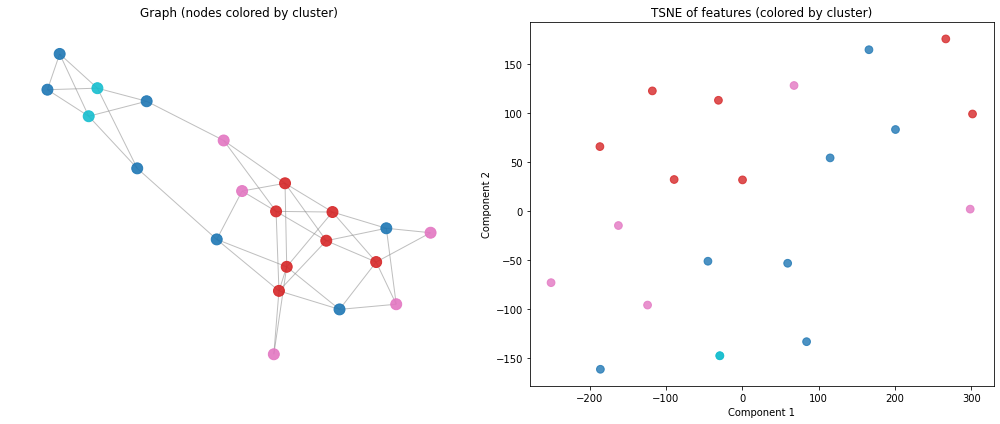

In [18]:
def plot_graph_and_tsne(adj_matrix,
                        feature_matrix,
                        cluster_ids,
                        layout_fn=nx.spring_layout,
                        cmap_name='tab10',
                        seed=42):
    """
    Plots side-by-side:
      • the graph from adj_matrix, colored by cluster_ids
      • a TSNE embedding of feature_matrix, colored by cluster_ids

    Parameters
    ----------
    adj_matrix    : (N, N) array-like
                    Binary or weighted adjacency matrix.
    feature_matrix: (N, D) array-like
                    Node features.
    cluster_ids   : (N,) array-like of ints
                    Cluster label for each node (need not be 0..C-1).
    layout_fn     : NetworkX layout function (e.g. spring_layout).
    cmap_name     : Matplotlib colormap name (sampled at C colors).
    seed          : int, for reproducible layout & TSNE.
    """
    # — ensure numpy arrays
    A = np.asarray(adj_matrix)
    X = np.asarray(feature_matrix)

    X         = normalize(X, axis=1)
    mean_vec = X.mean(axis=0)
    X        -= mean_vec
    
    clusters = np.asarray(cluster_ids)

    # — remap arbitrary ints → 0..C-1
    unique = np.unique(clusters)
    id2idx = {cid: i for i, cid in enumerate(unique)}
    cidx   = np.array([id2idx[c] for c in clusters])
    C      = len(unique)

    # — build colormap & per-node colors
    cmap        = plt.cm.get_cmap(cmap_name, C)
    node_colors = cmap(cidx)

    # — build graph & compute layout
    G   = nx.from_numpy_array(A)
    pos = layout_fn(G)

    # — compute TSNE
    tsne    = TSNE(n_components=2, random_state=seed, perplexity= 15, init='pca')
    feat_2d = tsne.fit_transform(X)

    # — plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # graph: nodes colored by cluster
    nx.draw_networkx_nodes(G,
                           pos,
                           ax=ax1,
                           node_size=120,
                           node_color=node_colors,
                           alpha=0.9)
    nx.draw_networkx_edges(G,
                           pos,
                           ax=ax1,
                           edge_color='gray',
                           alpha=0.5)
    ax1.set_title('Graph (nodes colored by cluster)')
    ax1.axis('off')

    # TSNE scatter: colored by same cluster mapping
    ax2.scatter(feat_2d[:, 0],
                feat_2d[:, 1],
                c=cidx,
                cmap=cmap,
                s=60,
                alpha=0.8)
    ax2.set_title('TSNE of features (colored by cluster)')
    ax2.set_xlabel('Component 1')
    ax2.set_ylabel('Component 2')

    plt.tight_layout()
    plt.show()

# Call the function with the example data
plot_graph_and_tsne(adj_np, x_embed.cpu().detach().numpy(),s.argmax(dim=1).cpu().numpy())